Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


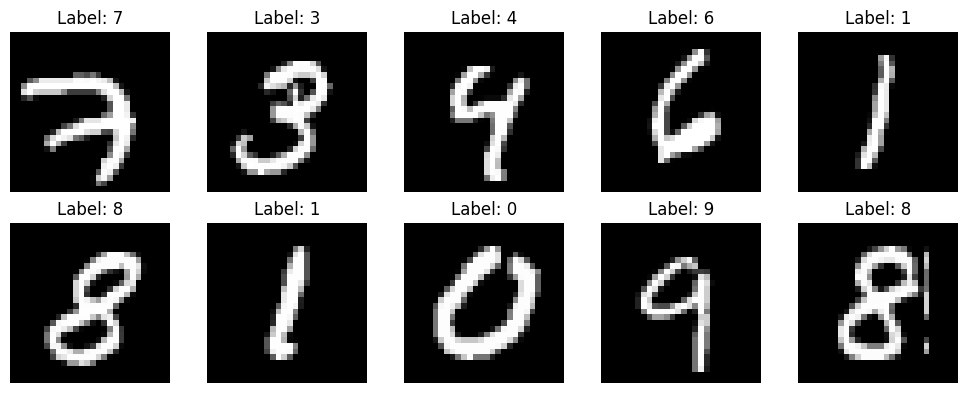

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


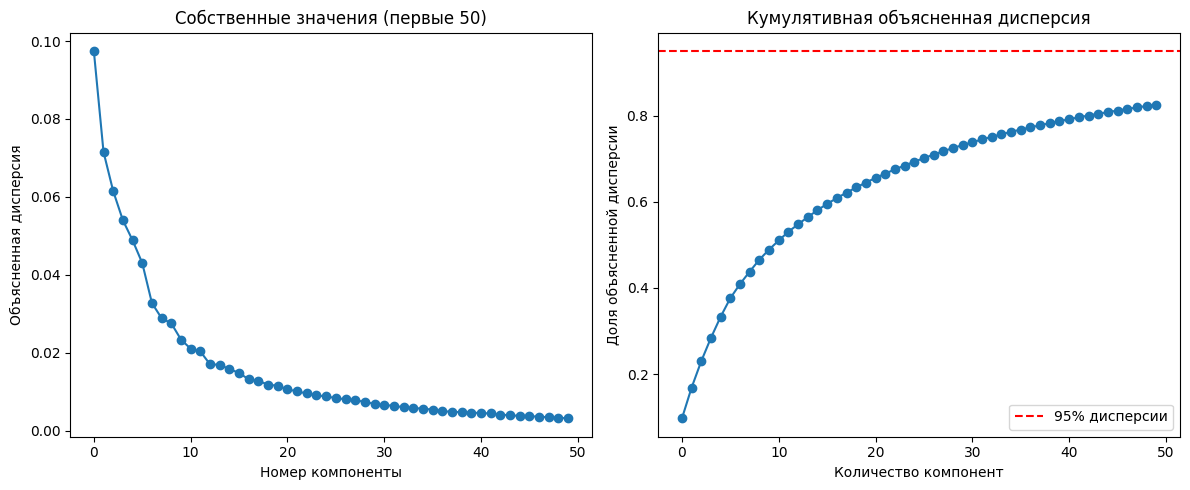

Доля дисперсии, покрываемая первыми 15 компонентами: 0.5805+0.0000j


/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


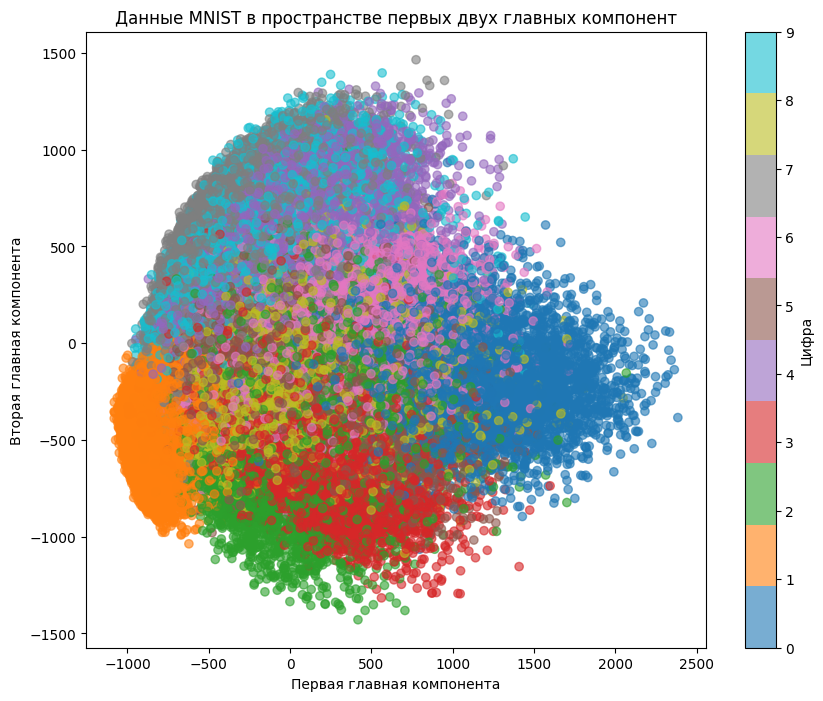

Точность kNN на исходных данных: 0.2794
Компоненты: 10, Соседи: 1, Точность: 0.9170
Компоненты: 10, Соседи: 3, Точность: 0.9279
Компоненты: 10, Соседи: 5, Точность: 0.9315
Компоненты: 10, Соседи: 7, Точность: 0.9311
Компоненты: 10, Соседи: 9, Точность: 0.9296
Компоненты: 10, Соседи: 11, Точность: 0.9292
Компоненты: 20, Соседи: 1, Точность: 0.9693
Компоненты: 20, Соседи: 3, Точность: 0.9721
Компоненты: 20, Соседи: 5, Точность: 0.9712
Компоненты: 20, Соседи: 7, Точность: 0.9711
Компоненты: 20, Соседи: 9, Точность: 0.9706
Компоненты: 20, Соседи: 11, Точность: 0.9698
Компоненты: 30, Соседи: 1, Точность: 0.9739
Компоненты: 30, Соседи: 3, Точность: 0.9768
Компоненты: 30, Соседи: 5, Точность: 0.9766
Компоненты: 30, Соседи: 7, Точность: 0.9754


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка данных MNIST
train, validation, test = load_mnist()

# Объединяем все данные для работы
X = np.concatenate([train[0], validation[0], test[0]])
y = np.concatenate([train[1], validation[1], test[1]])

# Преобразуем изображения 28x28 в одномерные векторы 784
X_flat = X.reshape(X.shape[0], -1)

# Визуализация нескольких примеров
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Реализация класса my_PCA
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        # Шаг 1: Центрирование данных
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Шаг 2: Вычисление матрицы ковариации
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Шаг 3: Вычисление собственных векторов и значений
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Сортируем собственные векторы по убыванию собственных значений
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Сохраняем компоненты
        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
        else:
            self.components = eigenvectors

        # Вычисляем объясненную дисперсию
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues / total_variance

        return self

    def transform(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("PCA must be fitted before transformation")

        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Реализация класса my_kNN
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        if self.X_train is None or self.y_train is None:
            raise ValueError("kNN must be fitted before prediction")

        predictions = []
        for x in X:
            # Вычисляем расстояния до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

            # Находим индексы k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Получаем классы ближайших соседей
            nearest_labels = self.y_train[nearest_indices]

            # Выбираем наиболее часто встречающийся класс
            unique, counts = np.unique(nearest_labels, return_counts=True)
            predicted_class = unique[np.argmax(counts)]
            predictions.append(predicted_class)

        return np.array(predictions)

# Анализ PCA
# Применяем PCA ко всем данным (используем плоские векторы)
pca = my_PCA()
X_pca_all = pca.fit_transform(X_flat)

# График собственных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_[:50], 'o-')
plt.title('Собственные значения (первые 50)')
plt.xlabel('Номер компоненты')
plt.ylabel('Объясненная дисперсия')

# График кумулятивной суммы объясненной дисперсии
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance[:50], 'o-')
plt.title('Кумулятивная объясненная дисперсия')
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% дисперсии')
plt.legend()

plt.tight_layout()
plt.show()

# Проверяем долю дисперсии, покрываемую первыми 15 компонентами
variance_15 = cumulative_variance[14]
print(f"Доля дисперсии, покрываемая первыми 15 компонентами: {variance_15:.4f}")

# Визуализация данных в пространстве первых двух главных компонент
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Цифра')
plt.title('Данные MNIST в пространстве первых двух главных компонент')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Применение kNN к исходным данным
knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)
print(f"Точность kNN на исходных данных: {accuracy_original:.4f}")

# Поиск оптимальных параметров для PCA + kNN
best_accuracy = 0
best_n_components = 0
best_n_neighbors = 0

# Перебираем различные комбинации параметров
n_components_list = [10, 20, 30, 40, 50, 64]
n_neighbors_list = [1, 3, 5, 7, 9, 11]

for n_components in n_components_list:
    # Применяем PCA
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for n_neighbors in n_neighbors_list:
        # Применяем kNN
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        y_pred_pca = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred_pca)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_components = n_components
            best_n_neighbors = n_neighbors

        print(f"Компоненты: {n_components}, Соседи: {n_neighbors}, Точность: {accuracy:.4f}")

print(f"\nЛучшая точность: {best_accuracy:.4f}")
print(f"Лучшее количество компонент: {best_n_components}")
print(f"Лучшее количество соседей: {best_n_neighbors}")

# Применяем лучшие параметры
pca_best = my_PCA(n_components=best_n_components)
X_train_best = pca_best.fit_transform(X_train)
X_test_best = pca_best.transform(X_test)

knn_best = my_kNN(n_neighbors=best_n_neighbors)
knn_best.fit(X_train_best, y_train)
y_pred_best = knn_best.predict(X_test_best)
final_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\nФинальная точность с лучшими параметрами: {final_accuracy:.4f}")

# Сравнение с исходной точностью
print(f"\nСравнение:")
print(f"Точность на исходных данных: {accuracy_original:.4f}")
print(f"Точность после PCA: {final_accuracy:.4f}")
print(f"Улучшение: {final_accuracy - accuracy_original:.4f}")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


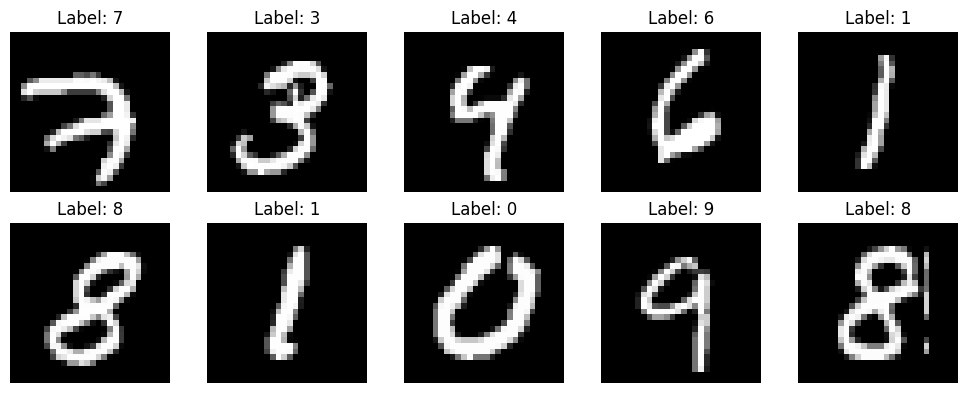

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


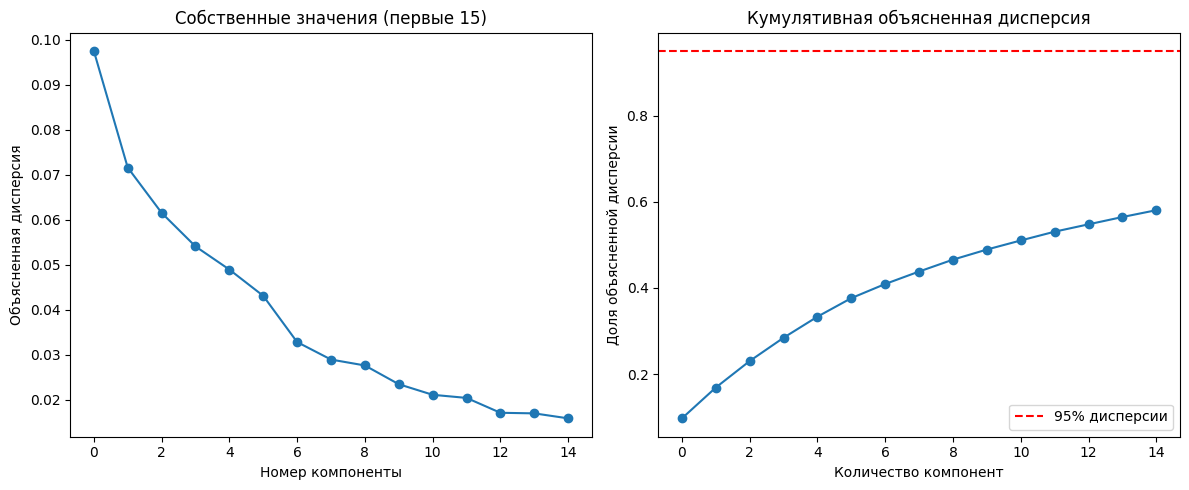

Доля дисперсии, покрываемая первыми 15 компонентами: 0.5805+0.0000j


/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


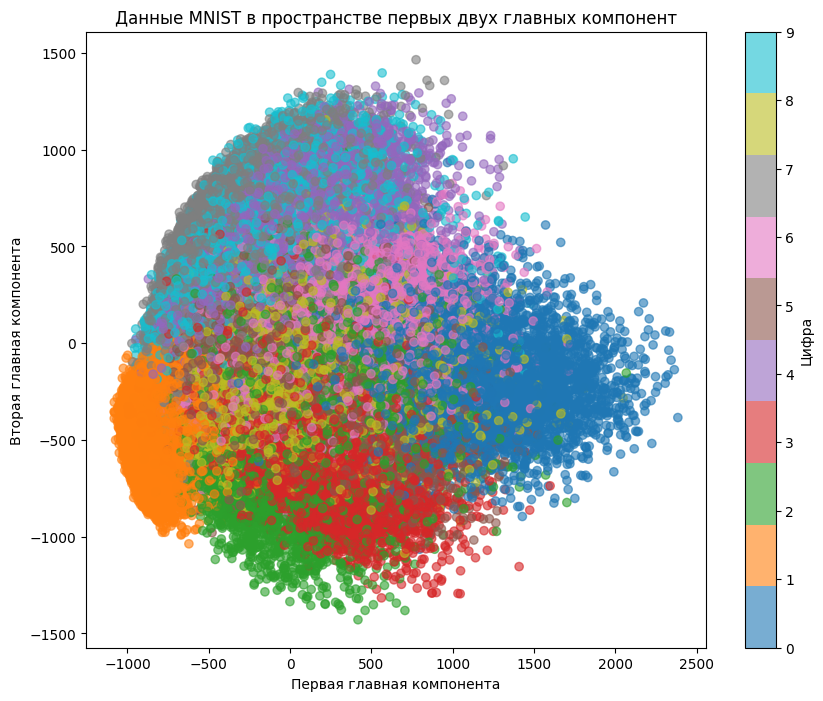

Точность kNN на исходных данных: 0.2794
Поиск оптимальных параметров:
Компоненты: 5, Соседи: 3, Точность: 0.7249
Компоненты: 5, Соседи: 5, Точность: 0.7405
Компоненты: 5, Соседи: 7, Точность: 0.7480
Компоненты: 10, Соседи: 3, Точность: 0.9279
Компоненты: 10, Соседи: 5, Точность: 0.9315
Компоненты: 10, Соседи: 7, Точность: 0.9311

Лучшая точность: 0.9315
Лучшее количество компонент: 10
Лучшее количество соседей: 5

Финальная точность с лучшими параметрами: 0.9315

Сравнение:
Точность на исходных данных: 0.2794
Точность после PCA: 0.9315
Улучшение: 0.6521

Точность при разном количестве компонент (с лучшими соседями):
Компоненты: 1, Точность: 0.2695
Компоненты: 2, Точность: 0.4144
Компоненты: 5, Точность: 0.7405
Компоненты: 10, Точность: 0.9315
Компоненты: 15, Точность: 0.9611
Компоненты: 20, Точность: 0.9712


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка данных MNIST
train, validation, test = load_mnist()

# Объединяем все данные для работы
X = np.concatenate([train[0], validation[0], test[0]])
y = np.concatenate([train[1], validation[1], test[1]])

# Преобразуем изображения 28x28 в одномерные векторы 784
X_flat = X.reshape(X.shape[0], -1)

# Визуализация нескольких примеров
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Реализация класса my_PCA
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        # Шаг 1: Центрирование данных
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Шаг 2: Вычисление матрицы ковариации
        cov_matrix = np.cov(X_centered, rowvar=False)

        # Шаг 3: Вычисление собственных векторов и значений
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Сортируем собственные векторы по убыванию собственных значений
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Сохраняем компоненты
        if self.n_components is not None:
            self.components = eigenvectors[:, :self.n_components]
        else:
            self.components = eigenvectors

        # Вычисляем объясненную дисперсию
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio_ = eigenvalues / total_variance

        return self

    def transform(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("PCA must be fitted before transformation")

        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Реализация класса my_kNN
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def predict(self, X):
        if self.X_train is None or self.y_train is None:
            raise ValueError("kNN must be fitted before prediction")

        predictions = []
        for x in X:
            # Вычисляем расстояния до всех точек обучающей выборки
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))

            # Находим индексы k ближайших соседей
            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            # Получаем классы ближайших соседей
            nearest_labels = self.y_train[nearest_indices]

            # Выбираем наиболее часто встречающийся класс
            unique, counts = np.unique(nearest_labels, return_counts=True)
            predicted_class = unique[np.argmax(counts)]
            predictions.append(predicted_class)

        return np.array(predictions)

# Анализ PCA
# Применяем PCA ко всем данным (используем плоские векторы)
pca = my_PCA()
X_pca_all = pca.fit_transform(X_flat)

# График собственных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_[:15], 'o-')
plt.title('Собственные значения (первые 15)')
plt.xlabel('Номер компоненты')
plt.ylabel('Объясненная дисперсия')

# График кумулятивной суммы объясненной дисперсии
plt.subplot(1, 2, 2)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance[:15], 'o-')
plt.title('Кумулятивная объясненная дисперсия')
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% дисперсии')
plt.legend()

plt.tight_layout()
plt.show()

# Проверяем долю дисперсии, покрываемую первыми 15 компонентами
variance_15 = cumulative_variance[14]
print(f"Доля дисперсии, покрываемая первыми 15 компонентами: {variance_15:.4f}")

# Визуализация данных в пространстве первых двух главных компонент
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c=y, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Цифра')
plt.title('Данные MNIST в пространстве первых двух главных компонент')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

# Применение kNN к исходным данным
knn = my_kNN(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)
print(f"Точность kNN на исходных данных: {accuracy_original:.4f}")

# Поиск оптимальных параметров для PCA + kNN (уменьшенное количество вариантов)
best_accuracy = 0
best_n_components = 0
best_n_neighbors = 0

# Перебираем только 5 и 10 компонент и 3 значения соседей
n_components_list = [5, 10]
n_neighbors_list = [3, 5, 7]

print("Поиск оптимальных параметров:")
for n_components in n_components_list:
    # Применяем PCA
    pca = my_PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for n_neighbors in n_neighbors_list:
        # Применяем kNN
        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_pca, y_train)
        y_pred_pca = knn.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred_pca)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_components = n_components
            best_n_neighbors = n_neighbors

        print(f"Компоненты: {n_components}, Соседи: {n_neighbors}, Точность: {accuracy:.4f}")

print(f"\nЛучшая точность: {best_accuracy:.4f}")
print(f"Лучшее количество компонент: {best_n_components}")
print(f"Лучшее количество соседей: {best_n_neighbors}")

# Применяем лучшие параметры
pca_best = my_PCA(n_components=best_n_components)
X_train_best = pca_best.fit_transform(X_train)
X_test_best = pca_best.transform(X_test)

knn_best = my_kNN(n_neighbors=best_n_neighbors)
knn_best.fit(X_train_best, y_train)
y_pred_best = knn_best.predict(X_test_best)
final_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\nФинальная точность с лучшими параметрами: {final_accuracy:.4f}")

# Сравнение с исходной точностью
print(f"\nСравнение:")
print(f"Точность на исходных данных: {accuracy_original:.4f}")
print(f"Точность после PCA: {final_accuracy:.4f}")
print(f"Улучшение: {final_accuracy - accuracy_original:.4f}")

# Дополнительно: проверяем точность с разным количеством компонент при лучшем количестве соседей
print("\nТочность при разном количестве компонент (с лучшими соседями):")
for n_components in [1, 2, 5, 10, 15, 20]:
    pca_test = my_PCA(n_components=n_components)
    X_train_test = pca_test.fit_transform(X_train)
    X_test_test = pca_test.transform(X_test)

    knn_test = my_kNN(n_neighbors=best_n_neighbors)
    knn_test.fit(X_train_test, y_train)
    y_pred_test = knn_test.predict(X_test_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    print(f"Компоненты: {n_components}, Точность: {accuracy_test:.4f}")